In [1]:
# ! git clone https://github.com/CodeArchitecture/FinRL.git

In [2]:
# import os
# os.chdir('/kaggle/working/FinRL')
# print(os.getcwd())

In [3]:
# ! pip install -r requirements.txt

In [4]:
from IPython.display import clear_output
clear_output(wait=True)

In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
import itertools
from datetime import timedelta 
from datetime import datetime
from finrl.config_tickers import CRYPTO_TICKERS
from finrl.main import clean_and_make_directories
from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR, INDICATORS

In [6]:
clean_and_make_directories([TRAINED_MODEL_DIR, RESULTS_DIR, os.path.join(RESULTS_DIR,'a2c'),
                            os.path.join(RESULTS_DIR,'ddpg'),os.path.join(RESULTS_DIR,'ppo'),
                            os.path.join(RESULTS_DIR,'td3'),os.path.join(RESULTS_DIR,'sac')])

In [7]:
TRAIN_START_DATE = '2020-01-01'
TRAIN_END_DATE = '2022-12-29'
TRADE_START_DATE = '2022-12-29'
TRADE_END_DATE = '2022-12-31'

TIMESTEPS = [10000,100,100,100,100]
# TIMESTEPS = [10000,10000,10000,10000,10000]

# '^DJI','000001.SS','^HSI', '^GDAXI'
# DOW_30_TICKER, SSE_50_TICKER, HSI_50_TICKER, DAX_30_TICKER
DATA_NAME = 'GDAXI'
PORTFOLIO = CRYPTO_TICKERS
BASELINES = '^GDAXI'

In [8]:
L=400
# download more date to compute tech indicator like macd
date = datetime.strptime(TRAIN_START_DATE, "%Y-%m-%d")
date = date - timedelta(days=L)
datetime.strftime(date, "%Y-%m-%d")
df = YahooDownloader(start_date = date,
                     end_date = TRADE_END_DATE,
                     ticker_list = PORTFOLIO).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4485, 8)


In [9]:
print(PORTFOLIO)

['BTC-USD', 'ETH-USD', 'XRP-USD']


In [10]:
df.shape

(4485, 8)

In [11]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2018-11-27,3765.949951,3862.959961,3661.010010,3820.719971,5998720000,BTC-USD,1
1,2018-11-27,107.913002,111.842003,102.452003,110.010002,2320010000,ETH-USD,1
2,2018-11-27,0.353977,0.367645,0.342991,0.360163,600169000,XRP-USD,1
3,2018-11-28,3822.469971,4385.899902,3822.469971,4257.419922,7280280000,BTC-USD,2
4,2018-11-28,110.197998,126.047997,110.197998,122.438004,2673470000,ETH-USD,2


In [12]:
df.tic.value_counts()

BTC-USD    1495
ETH-USD    1495
XRP-USD    1495
Name: tic, dtype: int64

In [13]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1030, 8)
Successfully added vix
Successfully added turbulence index


In [14]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [15]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2018-11-27,BTC-USD,3765.949951,3862.959961,3661.010010,3820.719971,5.998720e+09,1.0,0.000000,4656.656940,3421.482953,100.000000,66.666667,100.000000,3820.719971,3820.719971,19.020000,0.0
1,2018-11-27,ETH-USD,107.913002,111.842003,102.452003,110.010002,2.320010e+09,1.0,0.000000,4656.656940,3421.482953,100.000000,66.666667,100.000000,110.010002,110.010002,19.020000,0.0
2,2018-11-27,XRP-USD,0.353977,0.367645,0.342991,0.360163,6.001690e+08,1.0,0.000000,4656.656940,3421.482953,100.000000,66.666667,100.000000,0.360163,0.360163,19.020000,0.0
3,2018-11-28,BTC-USD,3822.469971,4385.899902,3822.469971,4257.419922,7.280280e+09,2.0,9.797755,4656.656940,3421.482953,100.000000,66.666667,100.000000,4039.069946,4039.069946,18.490000,0.0
4,2018-11-28,ETH-USD,110.197998,126.047997,110.197998,122.438004,2.673470e+09,2.0,0.278833,133.799851,98.648155,100.000000,66.666667,100.000000,116.224003,116.224003,18.490000,0.0
5,2018-11-28,XRP-USD,0.360313,0.401583,0.360313,0.390557,7.748180e+08,2.0,0.000682,0.418344,0.332376,100.000000,66.666667,100.000000,0.375360,0.375360,18.490000,0.0
6,2018-11-29,BTC-USD,4269.004395,4413.020508,4145.765137,4278.846680,6.503348e+09,3.0,13.148727,4636.068075,3601.922973,100.000000,71.337214,100.000000,4118.995524,4118.995524,18.790001,0.0
7,2018-11-29,ETH-USD,122.721550,123.229721,115.297691,117.542648,2.196099e+09,3.0,0.203484,129.184480,104.142623,71.048973,44.072350,100.000000,116.663551,116.663551,18.790001,0.0
8,2018-11-29,XRP-USD,0.391862,0.392465,0.373789,0.379562,6.299006e+08,3.0,0.000528,0.407539,0.345982,72.768377,43.645623,100.000000,0.376761,0.376761,18.790001,0.0
9,2018-11-30,BTC-USD,4289.088867,4322.976562,3942.822021,4017.268555,6.048017e+09,4.0,4.906395,4527.834502,3659.293062,62.110033,7.547508,40.828984,4093.563782,4093.563782,18.070000,0.0


In [16]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

2262
3


In [17]:
train.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-01-02,BTC-USD,7202.551270,7212.155273,6935.270020,6985.470215,2.080208e+10,3.0,-79.166603,7582.223523,6832.420032,41.640040,-114.879699,16.390012,7264.120752,7722.934074,12.47,0.795134
0,2020-01-02,ETH-USD,130.820038,130.820038,126.954910,127.410179,8.032709e+09,3.0,-4.856280,140.925608,120.617456,39.045408,-66.466930,22.607866,136.310122,153.279048,12.47,0.795134
0,2020-01-02,XRP-USD,0.192708,0.192896,0.186947,0.188043,1.085351e+09,3.0,-0.008392,0.213426,0.177970,36.404763,-73.877448,52.141332,0.205001,0.229716,12.47,0.795134
1,2020-01-03,BTC-USD,6984.428711,7413.715332,6914.996094,7344.884277,2.811148e+10,4.0,-63.736756,7595.938859,6840.725741,46.490515,-22.243195,2.176178,7267.215739,7688.471940,14.02,1.457921
1,2020-01-03,ETH-USD,127.411263,134.554016,126.490021,134.171707,1.047685e+10,4.0,-4.198361,138.934997,121.738315,43.109319,-36.239113,9.954751,135.890921,152.409323,14.02,1.457921


In [18]:
train.tail(2)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
753,2022-12-28,ETH-USD,1212.736572,1213.128906,1185.702148,1189.986084,4.991670e+09,2.0,-13.622003,1317.389188,1143.973825,45.277745,-86.753793,30.742191,1242.175769,1280.901442,22.139999,0.485055
753,2022-12-28,XRP-USD,0.368122,0.368543,0.356136,0.356531,8.396177e+08,2.0,-0.008940,0.400258,0.328632,44.859171,-48.935257,22.026362,0.374267,0.390843,22.139999,0.485055


In [19]:
trade.head(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-12-29,BTC-USD,16552.322266,16651.755859,16508.683594,16642.341797,1.447224e+10,3.0,-125.238723,17676.032756,16215.386385,44.567542,-118.756899,25.395222,16981.878581,17346.799902,21.440001,1.911837
0,2022-12-29,ETH-USD,1190.010132,1204.141602,1188.360229,1201.595337,4.132234e+09,3.0,-13.779915,1313.670422,1141.423645,46.018453,-82.977357,30.742191,1241.665572,1274.414976,21.440001,1.911837
0,2022-12-29,XRP-USD,0.356524,0.357225,0.338911,0.342846,8.980225e+08,3.0,-0.009572,0.397197,0.327063,42.824613,-92.698302,35.133638,0.372410,0.388916,21.440001,1.911837


In [20]:
trade.tail(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-12-29,BTC-USD,16552.322266,16651.755859,16508.683594,16642.341797,1.447224e+10,3.0,-125.238723,17676.032756,16215.386385,44.567542,-118.756899,25.395222,16981.878581,17346.799902,21.440001,1.911837
0,2022-12-29,ETH-USD,1190.010132,1204.141602,1188.360229,1201.595337,4.132234e+09,3.0,-13.779915,1313.670422,1141.423645,46.018453,-82.977357,30.742191,1241.665572,1274.414976,21.440001,1.911837
0,2022-12-29,XRP-USD,0.356524,0.357225,0.338911,0.342846,8.980225e+08,3.0,-0.009572,0.397197,0.327063,42.824613,-92.698302,35.133638,0.372410,0.388916,21.440001,1.911837


In [21]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [22]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 3, State Space: 31


In [23]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [24]:
env_train, _ = StockTradingEnv(df = train, **env_kwargs).get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [25]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

### Agent 1: A2C


In [26]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

trained_a2c = agent.train_model(model=model_a2c, 
                             total_timesteps=TIMESTEPS[0]) if if_using_a2c else None

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
--------------------------------------
| time/                 |            |
|    fps                | 83         |
|    iterations         | 100        |
|    time_elapsed       | 6          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -4.24      |
|    explained_variance | -0.00988   |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -22.7      |
|    reward             | -33.661613 |
|    std                | 0.994      |
|    value_loss         | 2.7e+03    |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 101       |
|    iterations         | 200       |
|    time_elapsed       | 9         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -4.23    

In [27]:
trained_a2c.save('model.zip')

In [28]:
model=model_a2c.load('model.zip')

In [29]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
test_env, test_obs = e_trade_gym.get_sb_env()

# test_env.state = (
#                     [self.initial_amount]
#                     + self.data.close.values.tolist()
#                     + self.num_stock_shares
#                     + sum(
#                         (
#                             self.data[tech].values.tolist()
#                             for tech in self.tech_indicator_list
#                         ),
#                         [],
#                     )
#                 ) 

action, _states = model.predict(test_obs, deterministic=True)
            # test_obs, rewards, dones, info = test_env.step(action)
print(np.floor(action*env_kwargs['hmax']))
            # if dones[0]:
            #     break

[[100. 100.  74.]]


In [30]:
y

NameError: name 'y' is not defined

### Agent 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

trained_ddpg = agent.train_model(model=model_ddpg, 
                             total_timesteps=TIMESTEPS[1]) if if_using_ddpg else None

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


### Agent 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

trained_ppo = agent.train_model(model=model_ppo, 
                             total_timesteps=TIMESTEPS[2]) if if_using_ppo else None

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
--------------------------------
| time/              |         |
|    fps             | 190     |
|    iterations      | 1       |
|    time_elapsed    | 10      |
|    total_timesteps | 2048    |
| train/             |         |
|    reward          | 0.38178 |
--------------------------------


### Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

trained_td3 = agent.train_model(model=model_td3, 
                             total_timesteps=TIMESTEPS[3]) if if_using_td3 else None

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


### Agent 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

trained_sac = agent.train_model(model=model_sac, 
                             total_timesteps=TIMESTEPS[4]) if if_using_sac else None

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


## In-sample Performance

In [ ]:
insample_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)].drop_duplicates(subset=['date'])

count    2468.000000
mean       17.067127
std         6.812706
min         9.140000
25%        13.015000
50%        15.385000
75%        18.940001
max        82.690002
Name: vix, dtype: float64


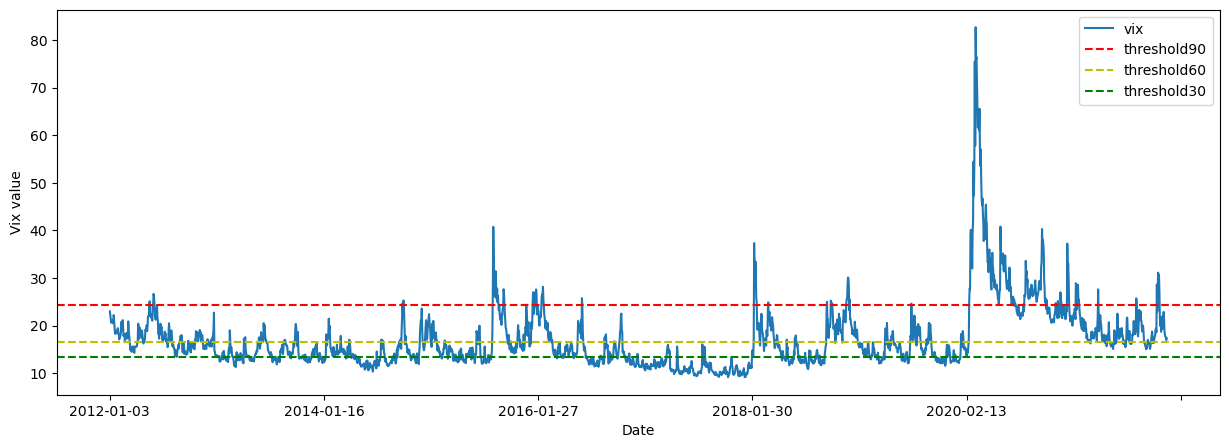

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
fig = insample_risk_indicator.set_index('date').vix.plot()
fig.axhline(y=insample_risk_indicator.vix.quantile(0.9), color='r', linestyle='--',label='threshold90')
fig.axhline(y=insample_risk_indicator.vix.quantile(0.6), color='y', linestyle='--',label='threshold60')
fig.axhline(y=insample_risk_indicator.vix.quantile(0.3), color='g', linestyle='--',label='threshold30')
fig.set_xlabel('Date')
fig.set_ylabel('Vix value')
fig.legend()
fig.get_figure().savefig('results/train_vix.png')

print(insample_risk_indicator.vix.describe())
insample_risk_indicator.vix.describe().to_csv('results/train_vix_describe.csv')

In [ ]:
insample_risk_indicator.turbulence.iloc[insample_risk_indicator.turbulence.values.argmax()]=200

count    2468.000000
mean       32.542209
std        40.970433
min         0.081096
25%        14.775007
50%        22.913304
75%        35.722207
max       734.067949
Name: turbulence, dtype: float64


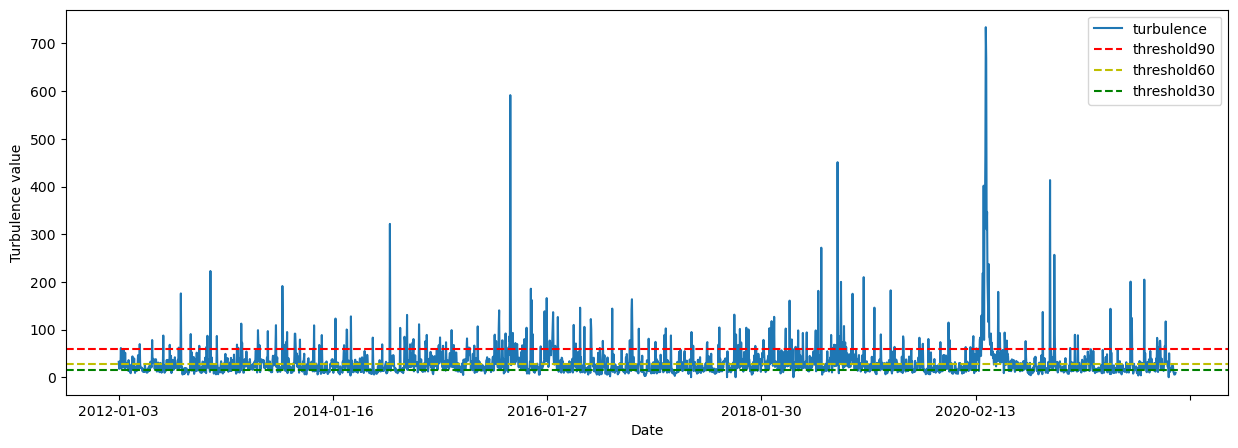

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
insample_risk_indicator.turbulence.describe()
fig = insample_risk_indicator.set_index('date').turbulence.plot()
fig.axhline(y=insample_risk_indicator.turbulence.quantile(0.9), color='r', linestyle='--',label='threshold90')
fig.axhline(y=insample_risk_indicator.turbulence.quantile(0.6), color='y', linestyle='--',label='threshold60')
fig.axhline(y=insample_risk_indicator.turbulence.quantile(0.3), color='g', linestyle='--',label='threshold30')
fig.set_xlabel('Date')
fig.set_ylabel('Turbulence value')
fig.legend()
fig.get_figure().savefig('results/train_turbulence')

print(insample_risk_indicator.turbulence.describe())
insample_risk_indicator.turbulence.describe().to_csv('results/train_turbulence_describe.csv')

In [ ]:
insample_risk_indicator = processed_full[(processed_full.date<TRADE_END_DATE) & (processed_full.date>=TRADE_START_DATE)].drop_duplicates(subset=['date'])

count    249.000000
mean      25.653655
std        4.219056
min       16.600000
25%       22.290001
50%       25.540001
75%       28.950001
max       36.450001
Name: vix, dtype: float64


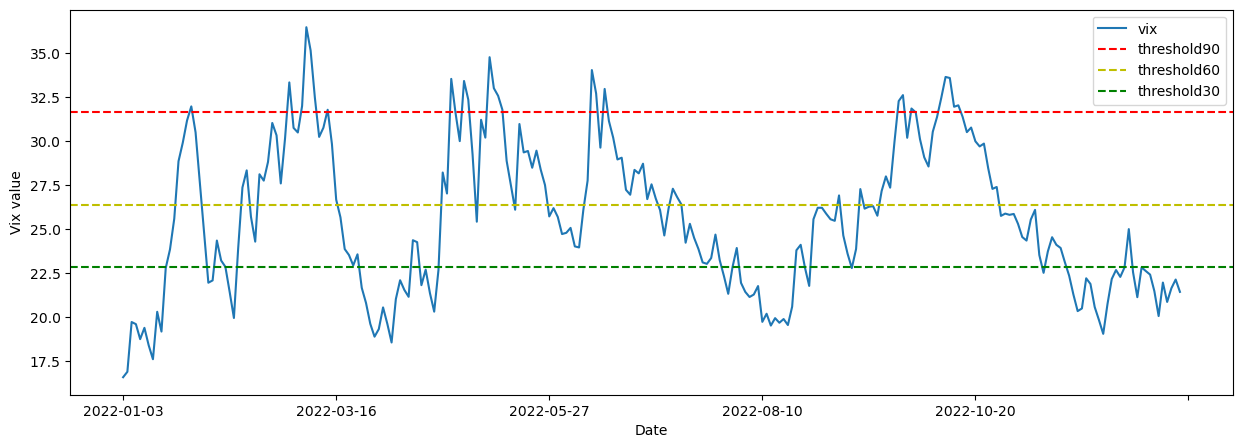

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
fig = insample_risk_indicator.set_index('date').vix.plot()
fig.axhline(y=insample_risk_indicator.vix.quantile(0.9), color='r', linestyle='--',label='threshold90')
fig.axhline(y=insample_risk_indicator.vix.quantile(0.6), color='y', linestyle='--',label='threshold60')
fig.axhline(y=insample_risk_indicator.vix.quantile(0.3), color='g', linestyle='--',label='threshold30')
fig.set_xlabel('Date')
fig.set_ylabel('Vix value')
fig.legend()
fig.get_figure().savefig('results/trade_vix.png')

print(insample_risk_indicator.vix.describe())
insample_risk_indicator.vix.describe().to_csv('results/trade_vix_describe.csv')

count    249.000000
mean      38.953532
std       35.629307
min        0.108666
25%       18.433986
50%       27.840453
75%       43.988829
max      274.978416
Name: turbulence, dtype: float64


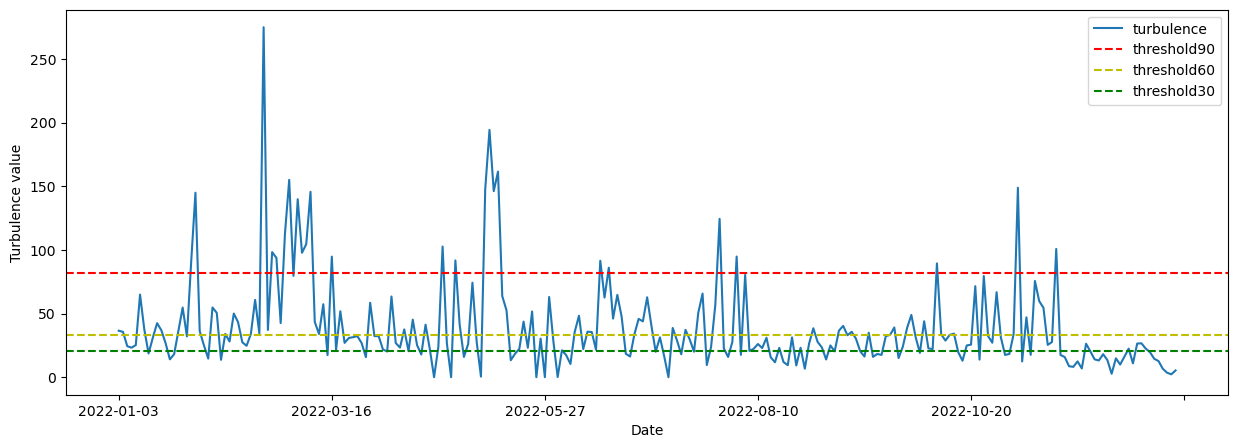

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
insample_risk_indicator.turbulence.describe()
fig = insample_risk_indicator.set_index('date').turbulence.plot()
fig.axhline(y=insample_risk_indicator.turbulence.quantile(0.9), color='r', linestyle='--',label='threshold90')
fig.axhline(y=insample_risk_indicator.turbulence.quantile(0.6), color='y', linestyle='--',label='threshold60')
fig.axhline(y=insample_risk_indicator.turbulence.quantile(0.3), color='g', linestyle='--',label='threshold30')
fig.set_xlabel('Date')
fig.set_ylabel('Turbulence value')
fig.legend()
fig.get_figure().savefig('results/trade_turbulence')

print(insample_risk_indicator.turbulence.describe())
insample_risk_indicator.turbulence.describe().to_csv('results/trade_turbulence_describe.csv')

In [ ]:
model_list = {'a2c':trained_a2c,'ddpg':trained_ddpg,'ppo':trained_ppo,'sac':trained_sac,'td3':trained_td3}
model_name_list = ['a2c','ddpg','ppo','sac','td3']
for i, model_name in enumerate(model_name_list):
    for j, vix_quantile in enumerate([0.3,0.6,0.9]):
        e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = insample_risk_indicator.vix.quantile(vix_quantile),risk_indicator_col='vix', **env_kwargs)
        trained_model = model_list[model_name]
        df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment = e_trade_gym)
        df_account_value.set_index(df_account_value.columns[0]).to_csv('results/{}/df_account_value_vix{}'.format(model_name,int(vix_quantile*100)))
        df_actions.to_csv('results/{}/df_actions_vix{}'.format(model_name,int(vix_quantile*100)))
    for j, turbulence_quantile in enumerate([0.3,0.6,0.9]):
        e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = insample_risk_indicator.turbulence.quantile(turbulence_quantile),risk_indicator_col='vix', **env_kwargs)
        trained_model = model_list[model_name]
        df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment = e_trade_gym)
        df_account_value.set_index(df_account_value.columns[0]).to_csv('results/{}/df_account_value_turbulence{}'.format(model_name,int(turbulence_quantile*100)))
        df_actions.to_csv('results/{}/df_actions_turbulence{}'.format(model_name,int(turbulence_quantile*100)))

KeyboardInterrupt: 

In [ ]:
# BASELINES = '^SSE'
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(ticker=BASELINES, start = TRADE_START_DATE, end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = pd.read_csv('results/a2c/df_account_value_turbulence90')['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("results/df_{}.csv".format(DATA_NAME))

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (257, 8)


d:\Anaconda\envs\fin\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


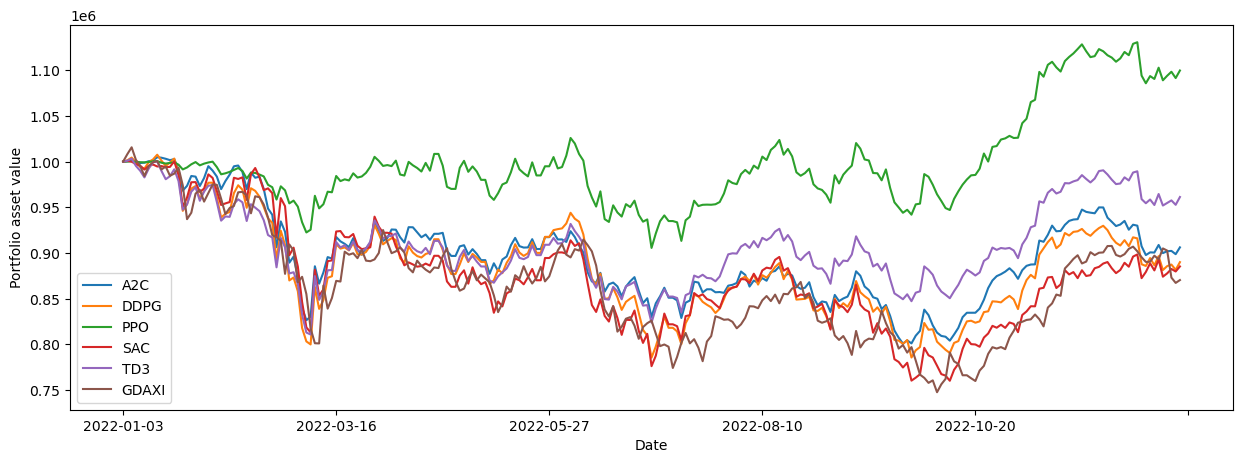

In [ ]:
%matplotlib inline
df1 = pd.read_csv('results/a2c/df_account_value_turbulence90',index_col=0)
df2 = pd.read_csv('results/ddpg/df_account_value_turbulence90',index_col=0)
df3 = pd.read_csv('results/ppo/df_account_value_turbulence90',index_col=0)
df4 = pd.read_csv('results/sac/df_account_value_turbulence90',index_col=0)
df5 = pd.read_csv('results/td3/df_account_value_turbulence90',index_col=0)
df6 = pd.read_csv('results/df_{}.csv'.format(DATA_NAME),index_col=0)

plt.rcParams["figure.figsize"] = (15,5)
df = pd.concat([df1,df2,df3,df4,df5,df6],axis=1)
df.columns=['A2C','DDPG','PPO','SAC','TD3', DATA_NAME]
fig = df.plot()
fig.set_xlabel('Date')
fig.set_ylabel('Portfolio asset value')
plt.legend()
fig.get_figure().savefig('results/backtest.png')

In [ ]:
import shutil
folder_name = 'results'
zip_file_name = 'results'
shutil.make_archive(zip_file_name, 'zip', folder_name)

'c:\\Users\\ThinkPad\\Desktop\\code\\FinRL\\results.zip'

In [ ]:
import pandas as pd
df_account_value = pd.read_csv('results_DAX/a2c/df_account_value_turbulence90')
pd.DataFrame(backtest_stats(account_value=df_account_value))

# pd.DataFrame(backtest_stats(account_value=df_account_value_a2c)).to_csv('results/a2c_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_ddpg)).to_csv('results/ddpg_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_td3)).to_csv('results/td3_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_ppo)).to_csv('results/ppo_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_sac)).to_csv('results/sac_perf.csv')

d:\Anaconda\envs\fin\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


,0
Annual return,-0.094957
Cumulative returns,-0.093882
Annual volatility,0.191213
Sharpe ratio,-0.428828
Calmar ratio,-0.467546
Stability,0.254787
Max drawdown,-0.203097
Omega ratio,0.928004
Sortino ratio,-0.607091
Skew,NaN
